# Selin's project

In [8]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from QG_functions import *

import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.periodic_table import Element
from pymatgen.io.cif import *

from ase.visualize import view


from pymatgen.io.ase import AseAtomsAdaptor
import sys

import re
import shutil as sh
import pickle
from tqdm import tqdm


import copy
from sklearn.metrics import mean_squared_error 

#import dataframe_image as dfi

from scipy import constants
from scipy.spatial import KDTree, distance_matrix

import matplotlib.pyplot as plt

import itertools
from itertools import chain

from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error as mse


k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]
# print(k_b)
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

import seaborn as sns
import time

from dadk.BinPol import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data we need:
- QUBO as a np.array read from file
- Structure read from a cif file

In [3]:
structure = Structure.from_file('data/limno2_initial_test_grid.cif')
structure

Structure Summary
Lattice
    abc : 9.8913 9.8682 8.9322
 angles : 90.0 90.0 90.0
 volume : 871.8660275924519
      A : np.float64(9.8913) np.float64(0.0) np.float64(6.056674442203107e-16)
      B : np.float64(-6.042529771672955e-16) np.float64(9.8682) np.float64(6.042529771672955e-16)
      C : np.float64(0.0) np.float64(0.0) np.float64(8.9322)
    pbc : True True True
PeriodicSite: Li0 (Li) (9.683, 7.304, 7.1) [0.9789, 0.7402, 0.7948]
PeriodicSite: Li1 (Li) (9.676, 7.499, 5.047) [0.9783, 0.7599, 0.565]
PeriodicSite: Li2 (Li) (9.681, 7.432, 1.563) [0.9787, 0.7531, 0.175]
PeriodicSite: Li3 (Li) (9.681, 2.498, 2.903) [0.9787, 0.2531, 0.325]
PeriodicSite: Li4 (Li) (4.735, 4.965, 6.029) [0.4787, 0.5031, 0.675]
PeriodicSite: Li5 (Li) (4.723, 9.628, 2.486) [0.4775, 0.9756, 0.2783]
PeriodicSite: Li6 (Li) (4.723, 9.629, 1.836) [0.4775, 0.9758, 0.2056]
PeriodicSite: Li7 (Li) (4.75, 0.2587, 3.866) [0.4803, 0.02622, 0.4328]
PeriodicSite: Li8 (Li) (4.735, 4.965, 7.369) [0.4787, 0.5031, 0.825]
Per

In [4]:
QUBO = np.genfromtxt('data/QUBO_models/limno2_initial.csv',delimiter=',')
QUBO = np.triu(QUBO)
# np.fill_diagonal(QUBO,0)

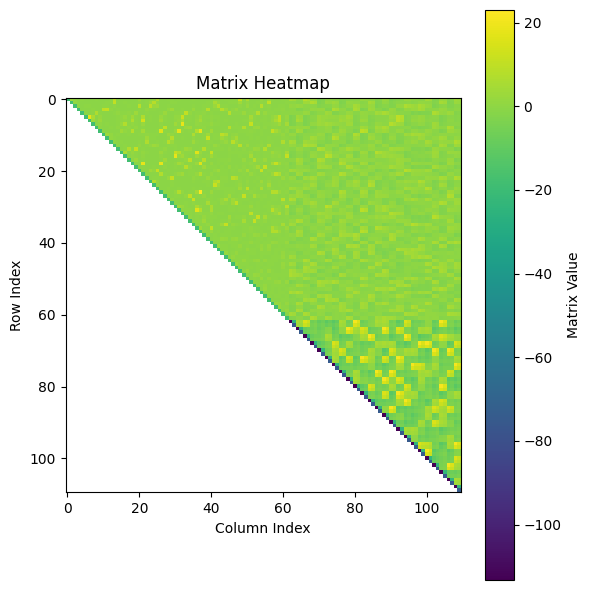

In [5]:
plot_matrix_heatmap(QUBO)

## Build QUBO model

#### All QUBO first

In [17]:
# Parameters
# Constraint parameters
one_hot_value = 500 # This is the lambda for the Mn3+/Mn4+ encoding
N_li = 5 # The number of Mn3+ is the same as N_li
weight = 1000 # This is the lambda for the number of Li and Mn3+

In [18]:
QUBO = np.genfromtxt('data/QUBO_models/limno2_initial.csv',delimiter=',')
QUBO = np.triu(QUBO)

li_indices = np.arange(62)
mn_indices = np.arange(62,110)

N = QUBO.shape[0]


# One-hot
QUBO_constraints = np.zeros(QUBO.shape)

for i in mn_indices[::2]:
    QUBO_constraints[i][i] += -one_hot_value
    QUBO_constraints[i][i+1] += 2*one_hot_value


for i in li_indices:
    QUBO_constraints[i][i] += weight*(1-2*N_li)
    for j in li_indices:
        if j > i:
            QUBO_constraints[i][j] += weight*2

# (10) = Mn4+ (01) = Mn3+
for i in mn_indices[1::2]:
    QUBO_constraints[i][i] += weight*(1-2*N_li)
    for j in mn_indices:
        if j > i:
            QUBO_constraints[i][j] += weight*2

QUBO_full = QUBO + QUBO_constraints

limno2_poly = BinPol()

for i in range(N):
    limno2_poly.set_term(QUBO_full[i][i],(i,))
    for j in range(i,N):
        limno2_poly.set_term(QUBO_full[i][j],(i,j))

print(f'LiMnO2 QUBO: {limno2_poly}')

LiMnO2 QUBO: - 9018.405840466006 x_0 + 2003.2199477635188 x_0 x_1 + 2000.890587630067 x_0 x_2 + 1999.4851904536513 x_0 x_3 + 1999.5983481298113 x_0 x_4 + 1999.2882393430775 x_0 x_5 + 1999.3137375923554 x_0 x_6 + 1999.2780987407034 x_0 x_7 + 1999.6467313406163 x_0 x_8 + 1999.583011102236 x_0 x_9 + 1999.5217152756745 x_0 x_10 + 1999.5695074993187 x_0 x_11 + 2000.0088547969256 x_0 x_12 + 2009.4959983448525 x_0 x_13 + 1999.2828201935508 x_0 x_14 + 1999.52711601003 x_0 x_15 + 1999.4909245625233 x_0 x_16 + 1999.3261761901088 x_0 x_17 + 1999.359528362943 x_0 x_18 + 1999.3581469335734 x_0 x_19 + 2002.5516074124844 x_0 x_20 + 1999.2920054365022 x_0 x_21 + 1999.936167256321 x_0 x_22 + 2000.4726301374428 x_0 x_23 + 2001.0586764128311 x_0 x_24 + 2006.5059222492257 x_0 x_25 + 1999.43038737284 x_0 x_26 + 1999.539634564978 x_0 x_27 + 1999.8875351695785 x_0 x_28 + 1999.7743495087916 x_0 x_29 + 1999.5685542567007 x_0 x_30 + 1999.6371802022857 x_0 x_31 + 1999.237279968764 x_0 x_32 + 1999.4656441463408 x

In [19]:
print(f"Polynomial limno2_poly: {limno2_poly}")

Polynomial limno2_poly: - 9018.405840466006 x_0 + 2003.2199477635188 x_0 x_1 + 2000.890587630067 x_0 x_2 + 1999.4851904536513 x_0 x_3 + 1999.5983481298113 x_0 x_4 + 1999.2882393430775 x_0 x_5 + 1999.3137375923554 x_0 x_6 + 1999.2780987407034 x_0 x_7 + 1999.6467313406163 x_0 x_8 + 1999.583011102236 x_0 x_9 + 1999.5217152756745 x_0 x_10 + 1999.5695074993187 x_0 x_11 + 2000.0088547969256 x_0 x_12 + 2009.4959983448525 x_0 x_13 + 1999.2828201935508 x_0 x_14 + 1999.52711601003 x_0 x_15 + 1999.4909245625233 x_0 x_16 + 1999.3261761901088 x_0 x_17 + 1999.359528362943 x_0 x_18 + 1999.3581469335734 x_0 x_19 + 2002.5516074124844 x_0 x_20 + 1999.2920054365022 x_0 x_21 + 1999.936167256321 x_0 x_22 + 2000.4726301374428 x_0 x_23 + 2001.0586764128311 x_0 x_24 + 2006.5059222492257 x_0 x_25 + 1999.43038737284 x_0 x_26 + 1999.539634564978 x_0 x_27 + 1999.8875351695785 x_0 x_28 + 1999.7743495087916 x_0 x_29 + 1999.5685542567007 x_0 x_30 + 1999.6371802022857 x_0 x_31 + 1999.237279968764 x_0 x_32 + 1999.4656

## Solve QUBO
Parameters to test:
- number_iterations
- number_runs
- temperature (initial and final)

In [25]:
from dadk.QUBOSolverCPU import *

solver = QUBOSolverCPU(
    number_iterations=1000,
    number_runs=100,
    graphics=GraphicsDetail.ALL,
    scaling_action=ScalingAction.AUTO_SCALING,
    scaling_bit_precision=62)

solution_list = solver.minimize(limno2_poly)
print('duration', solution_list.solver_times.duration_execution)


********************************************************************************
  temperature_start:                       8.19814230e+02
  temperature_end:                         9.66940843e+01
  offset_increase_rate:                    2.61861807e+02
  duration:                                0.003 sec
********************************************************************************

  max_abs_coefficient:                   9074.570

********************************************************************************
Effective values (including scaling factor)
  scaling_factor:                           7.63761600e+06
  temperature_start:                        6.26142628e+09
  temperature_end:                          7.38512286e+08
  offset_increase_rate:                     1.99999993e+09
  duration:                                 0.002 sec
********************************************************************************

duration 0:00:00.154198


## Visualise solutions
The first dataframe reports all the solutions, including ones that potentially don't respect the constraints.

The second dataframe contains only the constraint respecting solutions.

In [26]:
import numpy as np
import pandas as pd

records = []

for sol in solution_list.solutions:
    config = np.array(sol.configuration)
    energy = sol.energy
    num_li = np.sum(config[li_indices])
    num_mn = np.sum(config[mn_indices[1::2]])
    not_one_hot = np.sum(config[mn_indices[1::2]] + config[mn_indices[::2]] != 1)
    
    records.append({
        'energy': energy,
        'num_li': num_li,
        'num_mn': num_mn,
        'not_one_hot': not_one_hot,
        'configuration': tuple(config),  # Make it hashable for grouping
    })

# Create DataFrame
df = pd.DataFrame(records)

# Group by configuration and count how many times each appears
grouped_df = (
    df.groupby('configuration')
      .agg({
          'energy': 'mean',
          'num_li': 'first',
          'num_mn': 'first',
          'not_one_hot': 'first',
      })
      .reset_index()
)

# Add count column
counts = df['configuration'].value_counts().rename('count')
grouped_df = grouped_df.merge(counts, left_on='configuration', right_index=True)

# Add QUBO_energy
grouped_df['QUBO_energy'] = grouped_df['configuration'].apply(lambda x: classical_energy(np.array(x), QUBO))

# Compute relative energy wrt QUBO_energy
min_qubo_energy = grouped_df['QUBO_energy'].min()
grouped_df['relative_energy'] = grouped_df['QUBO_energy'] - min_qubo_energy

# Reorder columns
cols = list(grouped_df.columns)
energy_idx = cols.index('energy')
cols.insert(energy_idx + 1, cols.pop(cols.index('QUBO_energy')))
cols.insert(energy_idx + 2, cols.pop(cols.index('relative_energy')))
grouped_df = grouped_df[cols]

# Sort by increasing energy
grouped_df = grouped_df.sort_values(by='energy').reset_index(drop=True)

# Display
grouped_df.head(100)

,configuration,energy,QUBO_energy,relative_energy,num_li,num_mn,not_one_hot,count
0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-4.750977e+11,-2704.976531,0.000000,5,5,0,1
1,"(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...",-4.750935e+11,-2704.420445,0.556086,5,5,0,1
2,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",-4.750898e+11,-2703.932501,1.044030,5,5,0,1
3,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-4.750866e+11,-2703.514490,1.462041,5,5,0,1
4,"(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.750828e+11,-2703.016682,1.959849,5,5,0,1
...,...,...,...,...,...,...,...,...
95,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.750137e+11,-2693.968983,11.007548,5,5,0,1
96,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.750118e+11,-2693.730285,11.246246,5,5,0,1
97,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.750066e+11,-2693.045555,11.930977,5,5,0,1
98,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.749982e+11,-2691.948289,13.028242,5,5,0,1


In [27]:
import numpy as np
import pandas as pd

# Extract all configurations and compute classical energies
configs = [tuple(sol.configuration) for sol in solution_list.solutions]
qubo_energies = [classical_energy(np.array(sol.configuration), QUBO) for sol in solution_list.solutions]

# Create a DataFrame
df = pd.DataFrame({'configuration': configs, 'energy': qubo_energies})

# Count repeated configurations
df['count'] = df.groupby('configuration')['configuration'].transform('count')

# Drop duplicates (keep one of each repeated configuration)
df = df.drop_duplicates(subset='configuration').reset_index(drop=True)

# Compute energy relative to the lowest
min_energy = df['energy'].min()
df['relative_energy'] = df['energy'] - min_energy

# Sort by increasing energy
df = df.sort_values(by='energy').reset_index(drop=True)

# Show the result
df.head(100)

,configuration,energy,count,relative_energy
0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-2704.976531,1,0.000000
1,"(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...",-2704.420445,1,0.556086
2,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",-2703.932501,1,1.044030
3,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-2703.514490,1,1.462041
4,"(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-2703.016682,1,1.959849
...,...,...,...,...
95,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-2693.968983,1,11.007548
96,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-2693.730285,1,11.246246
97,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-2693.045555,1,11.930977
98,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-2691.948289,1,13.028242
